In [1]:
import os
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [2]:
config_content = 'png/content.png'
config_style = 'png/style3.png'
config_max_size = 400
config_lr = 0.003
config_total_step = 2000
config_log_step = 10
config_sample_step = 500
config_style_weight = 100

In [3]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    image = Image.open(image_path)

    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)

    return image.to(device)

In [4]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super().__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features

    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [5]:
# Image preprocessing
# VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
# We use the same normalization statistics here.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                         std=(0.229, 0.224, 0.225))])

# Load content and style images
# Make the style image same size as the content image
content = load_image(config_content, transform, max_size=config_max_size)
style = load_image(config_style, transform, shape=[content.size(2), content.size(3)])

# Initialize a target image with the content image
target = content.clone().requires_grad_(True)

optimizer = torch.optim.Adam([target], lr=config_lr, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

for step in range(config_total_step):     
    # Extract multiple(5) conv feature vectors
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)

    style_loss = 0
    content_loss = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        # Compute content loss with target and content images
        content_loss += torch.mean((f1 - f2) ** 2)

        # Reshape convolutional feature maps
        _, c, h, w = f1.size()
        f1 = f1.view(c, h * w)
        f3 = f3.view(c, h * w)

        # Compute gram matrix
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())

        # Compute style loss with target and style images
        style_loss += torch.mean((f1 - f3) ** 2) / (c * h * w) 

    # Compute total loss, backprop and optimize
    loss = content_loss + config_style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step + 1) % config_log_step == 0:
        print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
               .format(step + 1, config_total_step, content_loss.item(), style_loss.item()))

    if (step + 1) % config_sample_step == 0:
        # Save the generated image
        denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
        img = target.clone().squeeze()
        img = denorm(img).clamp_(0, 1)
        torchvision.utils.save_image(img, 'output-{}.png'.format(step + 1))

Step [10/2000], Content Loss: 3.6269, Style Loss: 138.2530
Step [20/2000], Content Loss: 7.0188, Style Loss: 99.0656
Step [30/2000], Content Loss: 9.5510, Style Loss: 77.4998
Step [40/2000], Content Loss: 11.3823, Style Loss: 65.2844
Step [50/2000], Content Loss: 12.7500, Style Loss: 57.7457
Step [60/2000], Content Loss: 13.7568, Style Loss: 52.5727
Step [70/2000], Content Loss: 14.5186, Style Loss: 48.6767
Step [80/2000], Content Loss: 15.1189, Style Loss: 45.5382
Step [90/2000], Content Loss: 15.6228, Style Loss: 42.9088
Step [100/2000], Content Loss: 16.0507, Style Loss: 40.6438
Step [110/2000], Content Loss: 16.4258, Style Loss: 38.6607
Step [120/2000], Content Loss: 16.7573, Style Loss: 36.8992
Step [130/2000], Content Loss: 17.0492, Style Loss: 35.3246
Step [140/2000], Content Loss: 17.3103, Style Loss: 33.9051
Step [150/2000], Content Loss: 17.5494, Style Loss: 32.6145
Step [160/2000], Content Loss: 17.7784, Style Loss: 31.4342
Step [170/2000], Content Loss: 17.9900, Style Loss:

Step [1380/2000], Content Loss: 24.1693, Style Loss: 7.5004
Step [1390/2000], Content Loss: 24.1841, Style Loss: 7.4462
Step [1400/2000], Content Loss: 24.1981, Style Loss: 7.3924
Step [1410/2000], Content Loss: 24.2114, Style Loss: 7.3392
Step [1420/2000], Content Loss: 24.2244, Style Loss: 7.2864
Step [1430/2000], Content Loss: 24.2376, Style Loss: 7.2340
Step [1440/2000], Content Loss: 24.2513, Style Loss: 7.1821
Step [1450/2000], Content Loss: 24.2654, Style Loss: 7.1307
Step [1460/2000], Content Loss: 24.2800, Style Loss: 7.0797
Step [1470/2000], Content Loss: 24.2931, Style Loss: 7.0292
Step [1480/2000], Content Loss: 24.3071, Style Loss: 6.9792
Step [1490/2000], Content Loss: 24.3192, Style Loss: 6.9297
Step [1500/2000], Content Loss: 24.3309, Style Loss: 6.8807
Step [1510/2000], Content Loss: 24.3439, Style Loss: 6.8322
Step [1520/2000], Content Loss: 24.3570, Style Loss: 6.7841
Step [1530/2000], Content Loss: 24.3693, Style Loss: 6.7365
Step [1540/2000], Content Loss: 24.3829,

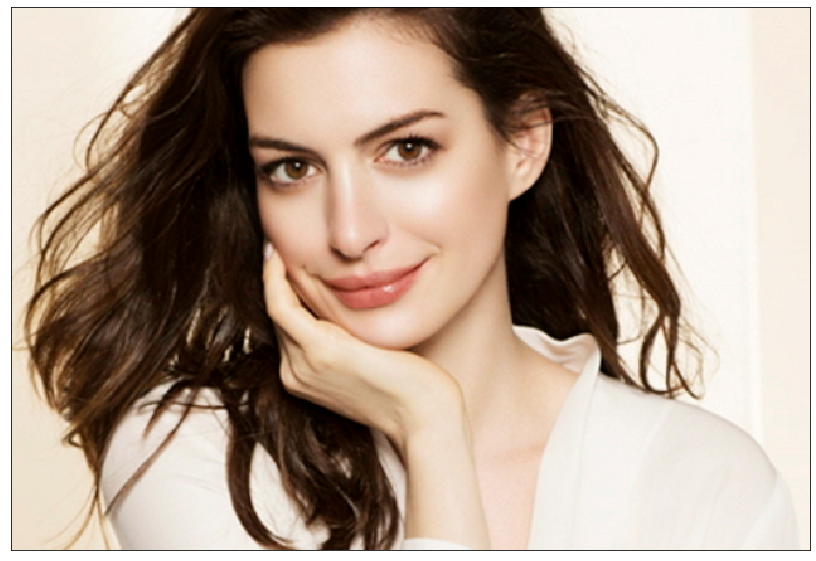

In [6]:
img = mpimg.imread('png/content.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

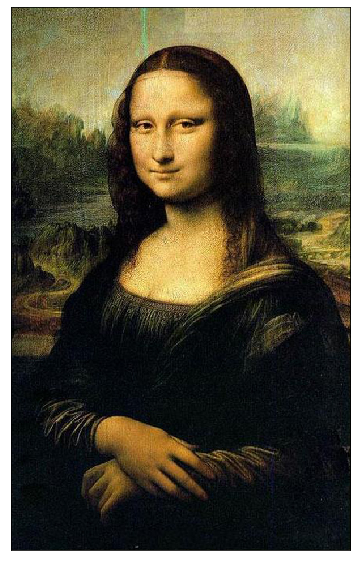

In [7]:
img = mpimg.imread('png/style3.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

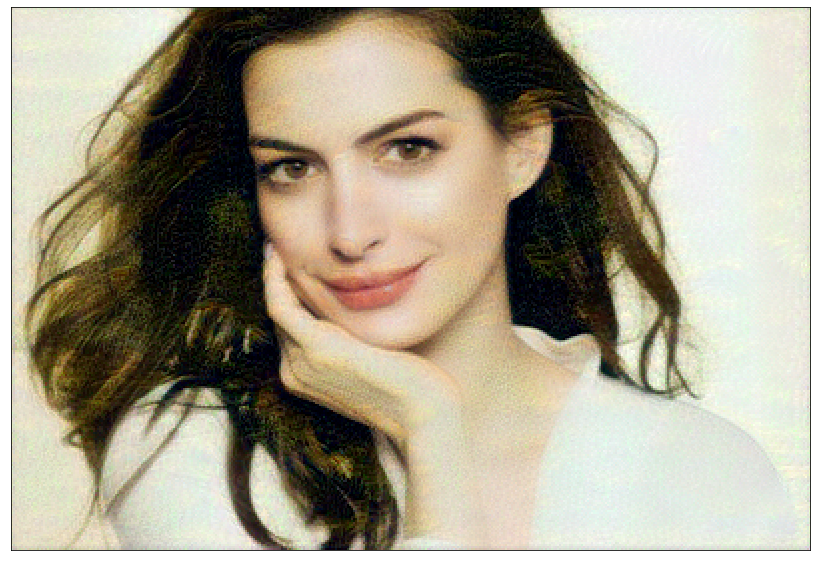

In [8]:
img = mpimg.imread('output-500.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

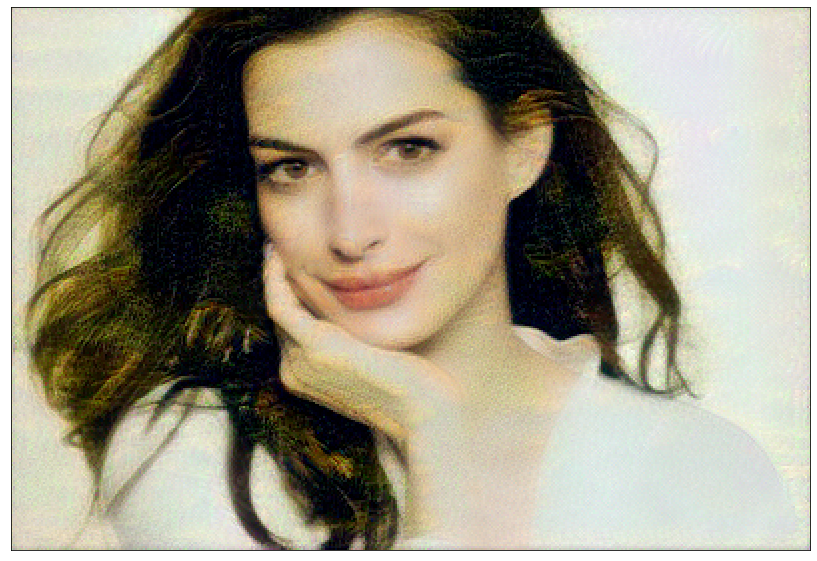

In [9]:
img = mpimg.imread('output-1000.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

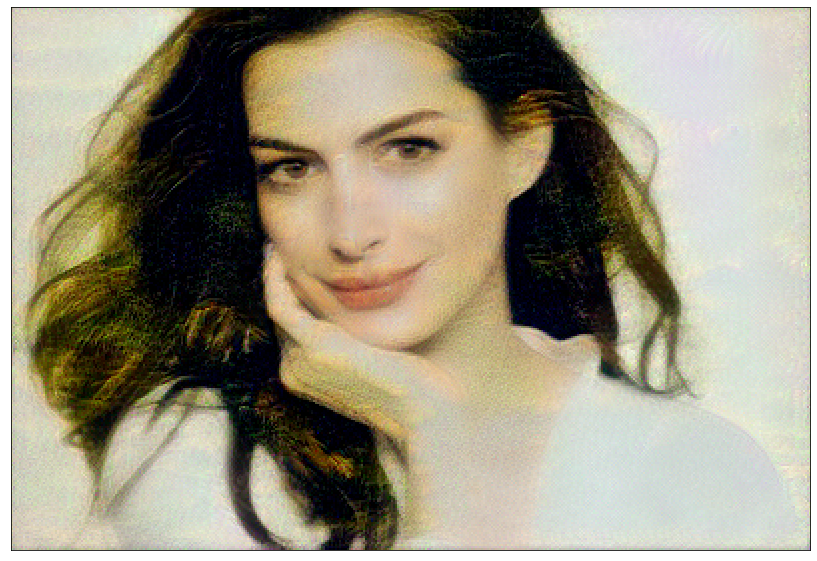

In [10]:
img = mpimg.imread('output-1500.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

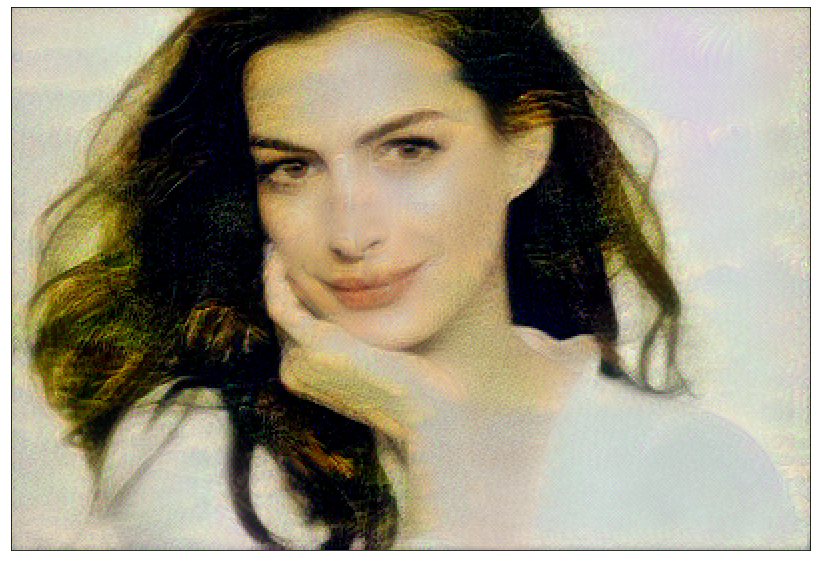

In [11]:
img = mpimg.imread('output-2000.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()